# RampUp Project
## Introduction

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
import textwrap
def paint(d):
    df = d.copy().reset_index()
    plt.figure(figsize=(12, 3))
    colors = ["red", "red", "green", "blue", "blue"]
    for i in range(len(df)):
        plt.scatter(i, df.loc[i, "X"], color=colors[df.loc[i, "y"]], marker='.')
    plt.show()

df = pd.read_csv("data.csv", index_col=0)
df.rename(columns={"yts": "X", "rampID": "y"}, inplace=True)
df["y"] -= 1

We have a series of subsequent values $y$ in the set $[0, 1, 2, 3, 4]$, where each sequence of subsequent identical values denote an event.
The values $y$ are affected in an _almost_ online fashion. Indeed, suppose the following sequence:

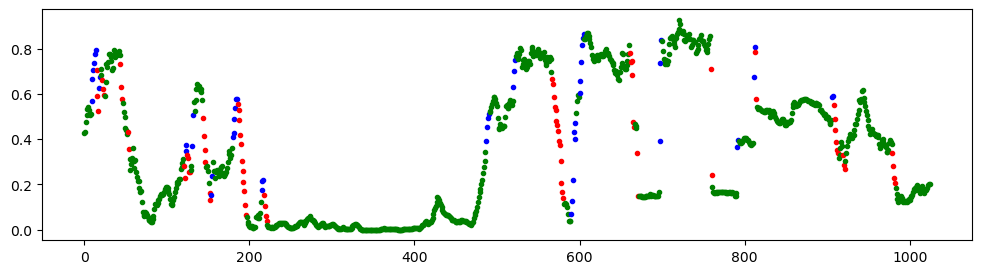

In [17]:
paint(df[25:1050])

If one would like to label the next point, it would only have access to the labels until the last purple section. The last red event being not yet finished, non of the points of this sequence can be labelled. However, the measured quantities are accessible in an online fashion.

## First strategy

As a first strategy, we try to compute the probability $P(y|z)$, where $z$ is the last finished event label, and $y$ is in $[0, 1, 2, 3, 4]$. This can be computed for all $z$ in $[0, 1, 2, 3, 4]$. We can then consider each event as an unique point, and then computing the probability of each sequence to be after one other.

In [18]:
sequence_of_event = [df.loc[0, "y"]]
for i in range(len(df)):
    if sequence_of_event[-1] != df.loc[i, "y"]:
        sequence_of_event.append(df.loc[i, "y"])

### Distribution of the events
Here is the distribution of events (the length of the events is not taken into account):

In [19]:
c = np.histogram(df["y"], bins=5)[0]
#c = [c[0]+c[1], c[2], c[3]+c[4]]

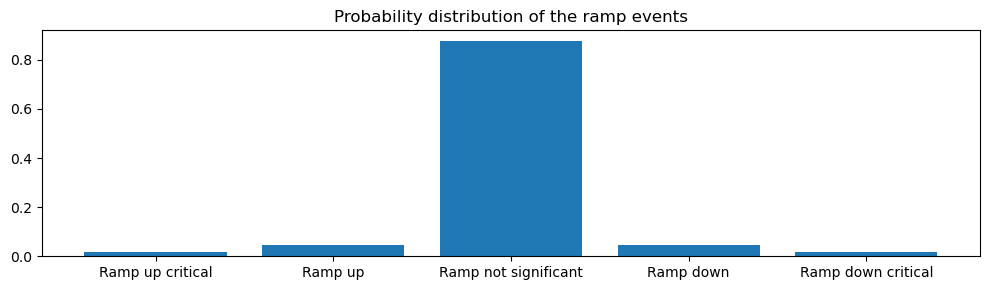

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plt.bar(['Ramp up critical', 'Ramp up', 'Ramp not significant', "Ramp down", "Ramp down critical"], c/c.sum())
plt.title("Probability distribution of the ramp events")
# plt.xlabel("Event")
# plt.ylabel("Probability of observation")
plt.tight_layout()
plt.savefig("probability_distribution.jpg")
plt.show()

This distribution can be sampled to randomly predict the next event (regardless of the current state).

Here are the probability distribution for the label following each label:

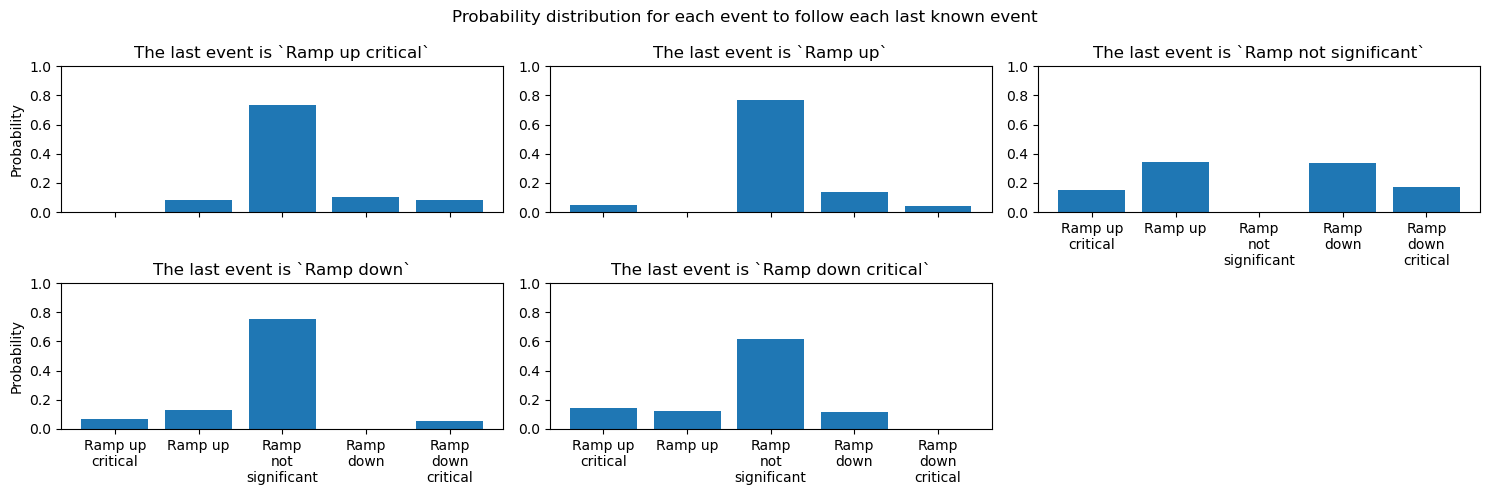

In [72]:
p = [[0 for _ in range(5)] for _ in range(5)]
for i in range(1, len(sequence_of_event)):
    p[sequence_of_event[i-1]][sequence_of_event[i]] += 1
p = np.array(p, dtype=np.float64)
p = (p.T / np.sum(p, axis=0)).T

type_of_event = ['Ramp up critical', 'Ramp up', 'Ramp not significant', "Ramp down", "Ramp down critical"]
new_labels = [textwrap.fill(text, width=7, break_long_words=False)for text in type_of_event]
index = 0
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
for i in range(2):
    for j in range(3):
        if i==1 and j==2:
            continue
        ax[i][j].bar(new_labels, p[index])
        ax[i][j].set_title(f"The last event is `{type_of_event[index]}`")
        ax[i][j].set_ylim((0, 1))
        if j == 0:
            ax[i][j].set_ylabel("Probability")
        
        if i == 0 and j<=1:
            ax[i][j].xaxis.set_ticklabels([])
        index += 1
plt.suptitle("Probability distribution for each event to follow each last known event")
ax[-1, -1].axis('off')
plt.tight_layout()
plt.savefig("event_succession_probability.jpg")

In [69]:
type_of_event

['Ramp\nup\ncritical',
 'Ramp\nup',
 'Ramp\nnot\nsignificant',
 'Ramp\ndown',
 'Ramp\ndown\ncritical']

We need a strategy for determining the length of the current event. Based on the previous event, we compute the probability distribution for each following event to have a given length.

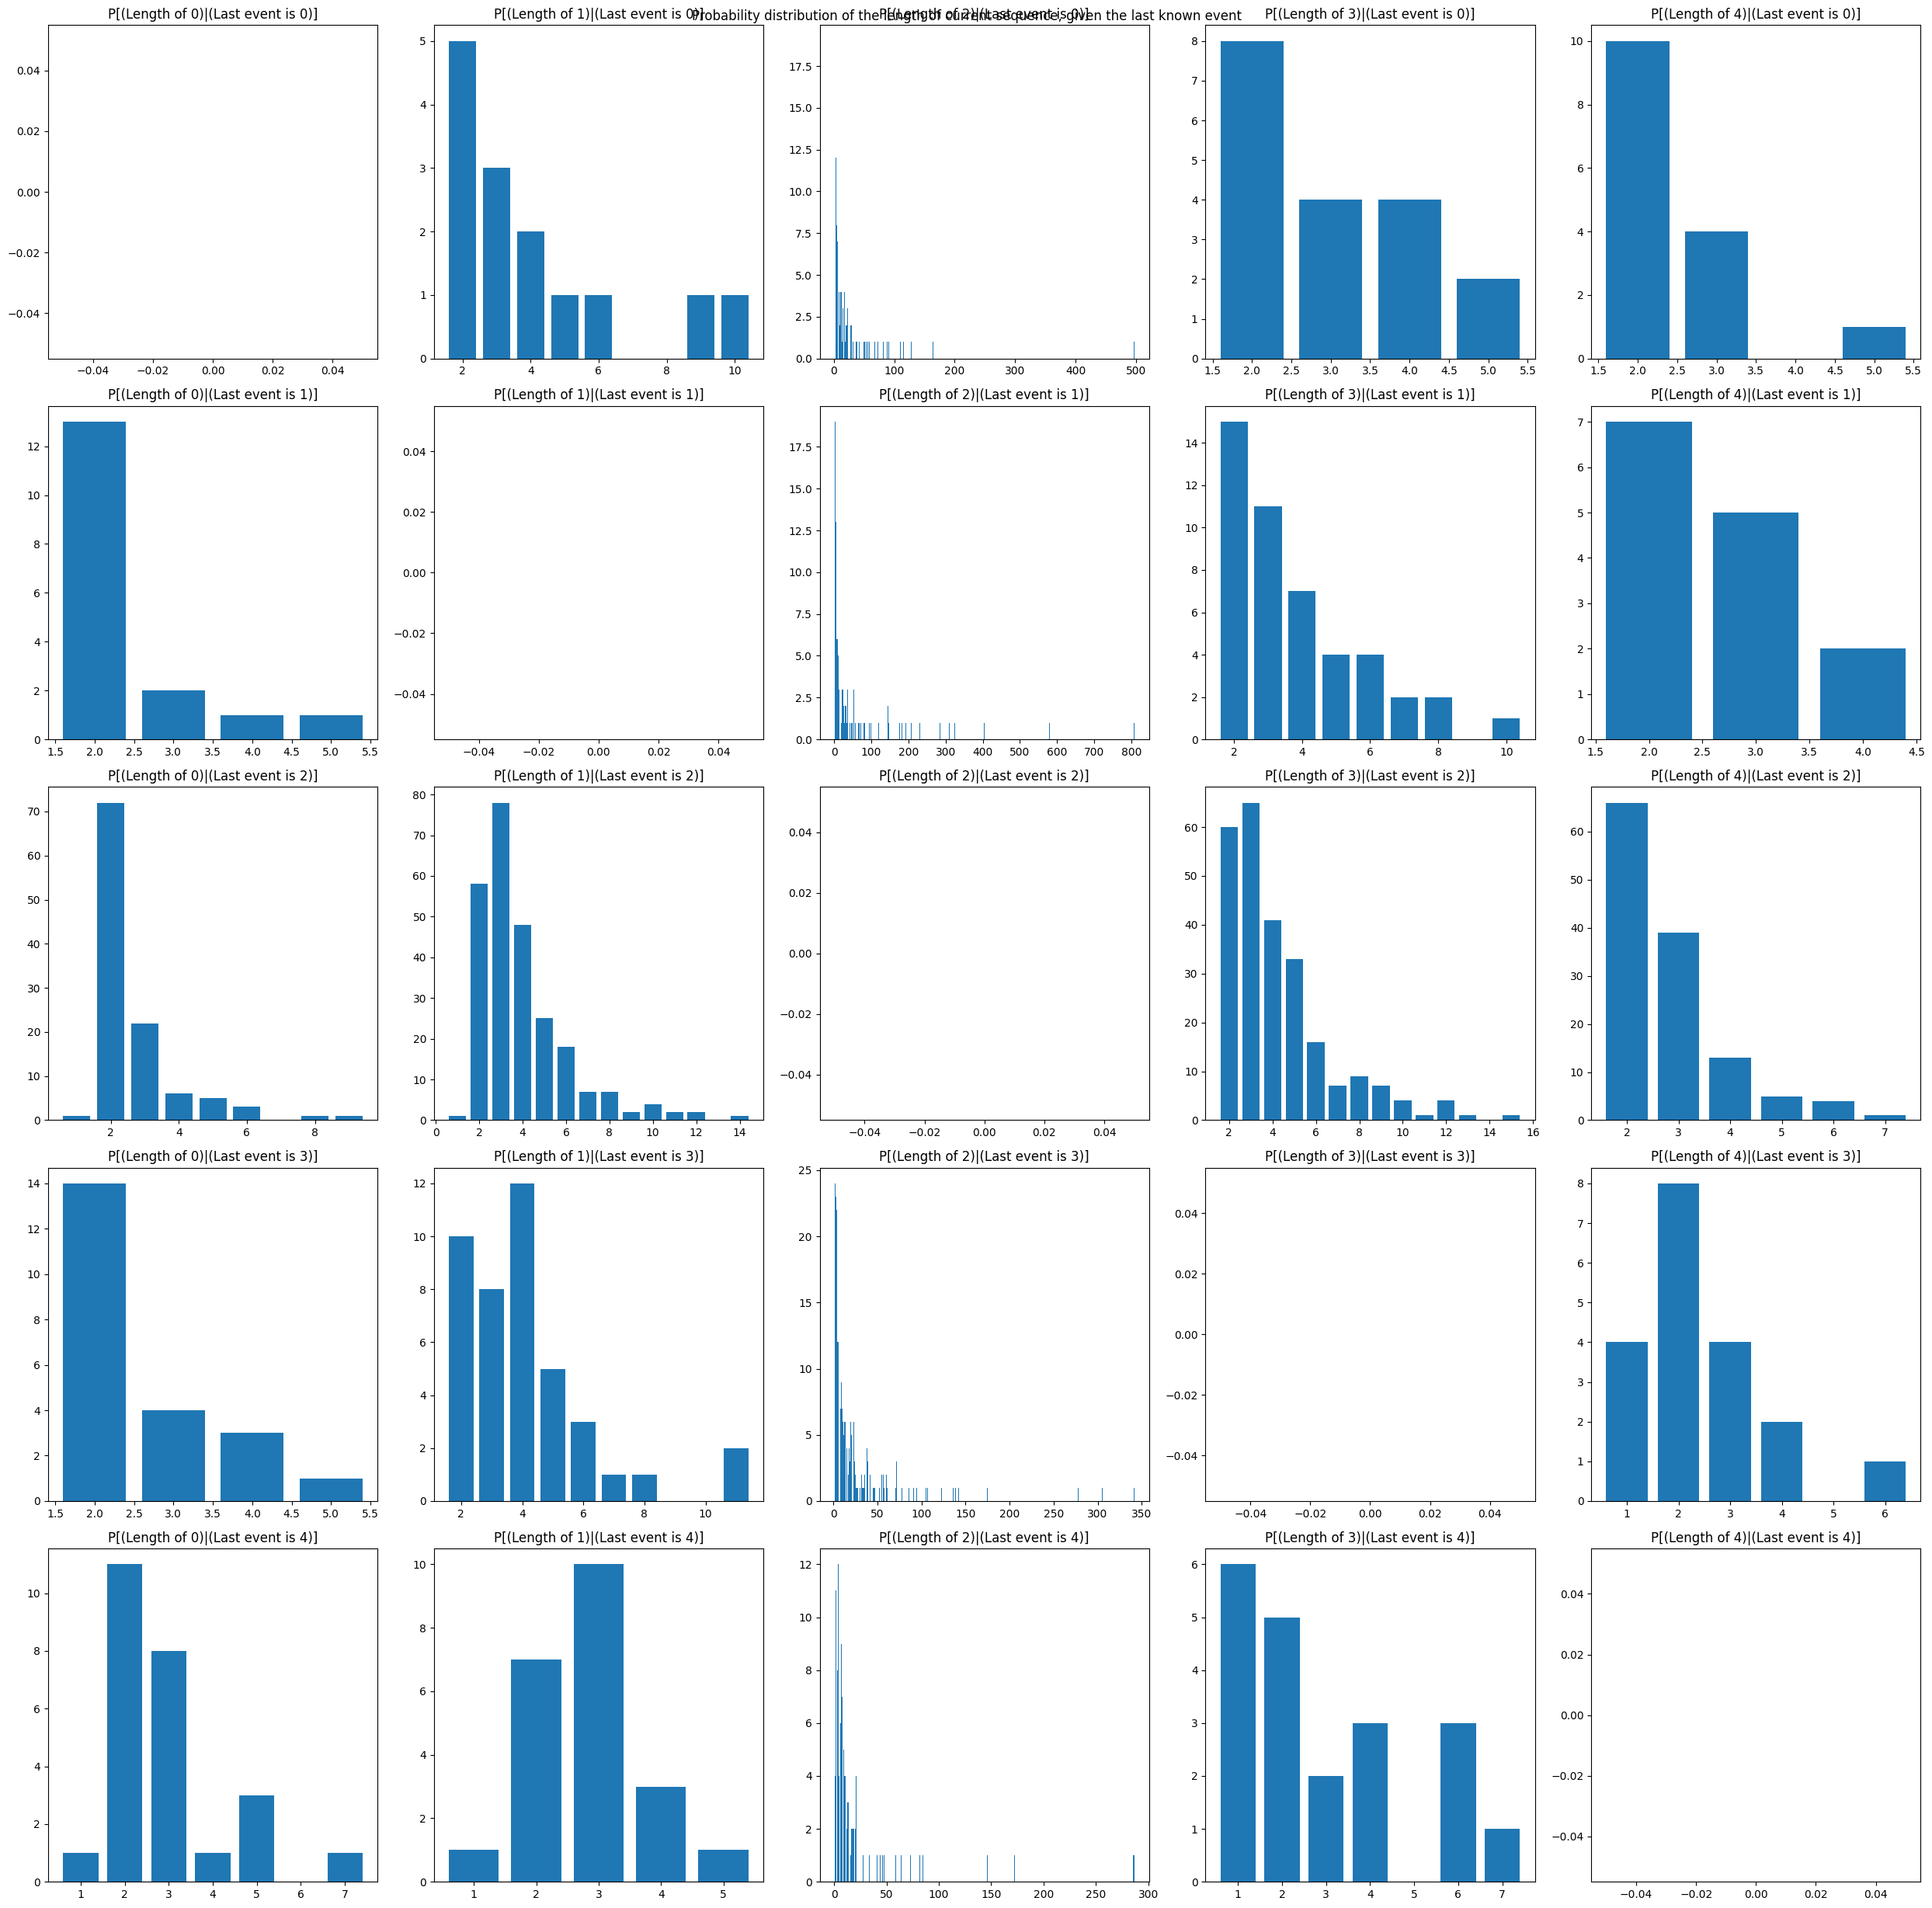

In [178]:
sequence_of_length = [[df.loc[0, "y"], 1]]
for i in range(len(df)):
    if sequence_of_length[-1][0] != df.loc[i, "y"]:
        sequence_of_length.append([df.loc[i, "y"], 1])
    else:
        sequence_of_length[-1][1] += 1

q = [[[] for _ in range(5)] for _ in range(5)]
for i in range(1, len(sequence_of_event)):
    q[sequence_of_length[i-1][0]][sequence_of_length[i][0]].append(sequence_of_length[i][1])

result = []

for sublist in q:
    sublist_result = []
    for inner_list in sublist:
        unique, counts = np.unique(inner_list, return_counts=True)
        count_dict = dict(zip(unique, counts))
        sublist_result.append(count_dict)
    result.append(sublist_result)

fig, ax = plt.subplots(5, 5, figsize=(25, 25))
for i in range(5):
    for j in range(5):
        ax[i, j].bar(list(result[i][j].keys()), list(result[i][j].values()))
        ax[i, j].set_title(f"P[(Length of %i)"%j+f"|(Last event is %i)]"%i)
plt.suptitle("Probability distribution of the length of current sequence, given the last known event")
#plt.tight_layout()
plt.show()